In [1]:
import pandas as pd

df = pd.read_excel('../../data/Outscraper.xlsx')


In [2]:
subdf=pd.read_csv('../../data/census_subset_clean.csv')

In [3]:
df[['population', 'median_income']] = subdf[['population', 'median_income']]

In [4]:
def categorize(text):
    for category, keywords in keyword_map.items():
        if any(keyword.lower() in text.lower() for keyword in keywords):
            return category
    return "other"  
keyword_map = {
    "Asian food": [
        "Vietnamese", "Sichuan", "Japanese", "Indonesian", "Thai", "Chinese", 
        "Korean", "Filipino", "Malaysian", "Taiwanese", "Pakistani", "Afghan", 
        "Nepalese", "Tibetan", "Cambodian", "Asian", "Pan-Asian", "Southeast Asian",
        "Dan Dan", "Pho", "Shabu-shabu", "Ramen"
    ],
    "European and US food": [
        "Italian", "European", "American", "Western", "US", "French", "Irish", 
        "Greek", "Portuguese", "German", "Spanish", "Swedish", "Polish", 
        "British", "Dutch", "Modern European", "Mid-Atlantic", "Southern Italian"
    ],
    "African food": [
        "Ethiopian", "Eritrean", "Moroccan", "Tunisian", "West African", "African"
    ],
    "Middle Eastern food": [
        "Lebanese", "Israeli", "Turkish", "Halal", "Kosher", "Georgian", "Yemeni"
    ],
    "Latin American and Caribbean food": [
        "Mexican", "Honduran", "Salvadoran", "Guatemalan", "Colombian", 
        "Brazilian", "Argentinian", "Peruvian", "Puerto Rican", "Cuban", 
        "Venezuelan", "Latin American", "Caribbean"
    ],
    "Indian food": [
        "Indian", "Modern Indian", "South Indian", "Indian takeaway"
    ],
    "Fast food": [
        "Pizza", "Fast food", "Fried chicken", "Hot dog", "Burger", 
        "Takeout", "Delivery", "Wings", "Donut", "Burrito", "Taco"
    ],
    "Vegan and healthy food": [
        "Vegan", "Vegetarian", "Organic", "Health food", "Salad", "Raw food", 
        "Juice", "Açaí", "Fresh food"
    ],
    "Desserts and snacks": [
        "Ice cream", "Dessert", "Snack", "Pretzel", "Bakery", "Creperie", "Donut"
    ],
    "Drinks and bars": [
        "Bar", "Cocktail", "Pub", "Brewery", "Beer", "Wine", "Liquor", 
        "Beer garden", "Brewpub", "Karaoke", "Hookah", "Lounge", "Club", 
        "Sports bar", "Coffee", "Tea", "Juice"
    ],
    "Seafood": [
        "Seafood", "Crab", "Oyster", "Fish & chips"
    ],
    "Buffet and mixed cuisine": [
        "Buffet", "Fusion", "Eclectic", "Dim sum", "Asian fusion"
    ],
    "Specialty or ethnic": [
        "Cambodian", "Uzbeki", "Ecuadorian", "Georgian", "Jewish", "Bangladeshi", "Laotian"
    ],
    "Catering and service": [
        "Caterer", "Catering", "Personal chef", "Mobile caterer", "Cooking class", 
        "Event", "Entertainment", "Catering equipment"
    ],
    "Other / uncategorized": [
        "Market", "Grocery", "Store", "Mall", "Hotel", "Bed & breakfast", 
        "Convenience store", "Food court", "Shopping", "Self service", 
        "Association", "Vitamin", "Smoke shop", "Lingerie"
    ]
}
df["category"] = df["type"].astype(str).apply(categorize)

In [5]:
df.groupby('type').rating.mean()
price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df['price'] = df['range'].map(price_mapping) 


In [6]:
df = df.dropna(subset=["rating"])
df["rating"] = df["rating"].fillna(df["rating"].median()) 
df = df.dropna(subset=["rating"])
df['price'].fillna(df['price'].median(), inplace=True)
df = df[df['city'].str.contains('Philadelphia', case=False, na=False)]

/var/folders/y6/68vnvhnn5lq29tm5q9k42_600000gn/T/ipykernel_11889/2910396506.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)


In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [13]:
n_splits=5
kfold = KFold(n_splits=5)

In [8]:
from datetime import datetime
def ensure_am_pm(time_str):
    time_str = time_str.strip()
    if 'am' in time_str.lower() or 'pm' in time_str.lower():
        return time_str.upper()
    if ':' in time_str:
        return time_str + 'AM'  # assume morning
    elif time_str.isdigit():
        return time_str + 'AM'  # assume morning
    return time_str

# Parse a single time range (e.g. '11:30AM-3PM')
def get_hours_from_range(time_range):
    start, end = time_range.split('-')

    start = ensure_am_pm(start)
    end = ensure_am_pm(end)

    # Parse with or without minutes
    try:
        start_dt = datetime.strptime(start, '%I:%M%p')
    except ValueError:
        start_dt = datetime.strptime(start, '%I%p')

    try:
        end_dt = datetime.strptime(end, '%I:%M%p')
    except ValueError:
        end_dt = datetime.strptime(end, '%I%p')

    duration = (end_dt - start_dt).seconds / 3600
    return duration

# Parse a full day's schedule (e.g. '11:30AM-3PM,5-10PM')
def calculate_operating_hours(day_schedule):
    if not isinstance(day_schedule, str):
        return 0.0
    day_schedule = day_schedule.strip().lower()

    if 'closed' in day_schedule:
        return 0.0
    if 'open 24 hours' in day_schedule:
        return 24.0

    total = 0.0
    for time_range in day_schedule.split(','):
        time_range = time_range.strip()
        if not time_range or 'open 24 hours' in time_range:
            continue
        try:
            total += get_hours_from_range(time_range)
        except Exception as e:
            print(f"Error parsing time '{time_range}': {e}")
    return total

# Parse a full week (e.g. 'Monday:10AM-9PM|Tuesday:Closed|...')
def calculate_total_operating_time(schedule_str):
    if not isinstance(schedule_str, str):
        return 0.0

    total_hours = 0.0
    for day in schedule_str.split('|'):
        if ':' not in day:
            continue
        day_name, day_schedule = day.split(':', 1)
        total_hours += calculate_operating_hours(day_schedule)
    return total_hours

# Example: apply to your DataFrame
# Assuming your dataframe is called df and the column is 'working_hours_old_format'
df['time'] = df['working_hours_old_format'].apply(calculate_total_operating_time)
df.loc[df['time'] == 0, 'time'] = df['time'].median()

In [9]:
df = df.loc[df.reviews >= 50] #we want to consider number f reviews as a factor and thus drop those without enough reviews

In [10]:
df = df[~df['name'].str.contains('truck', case=False, na=False)]# drop the food trucks

In [11]:
from geopy.distance import geodesic
city_center_coords = (39.9526, -75.1652)  # (lat, lon)

# Compute distance to City Hall and create new feature column
df['city_hall_distance_km'] = df.apply(
    lambda row: geodesic(city_center_coords, (row['latitude'], row['longitude'])).kilometers,
    axis=1
)

In [12]:
from requests import request

In [ ]:
url = "https://www3.septa.org/api/locations/get_locations.php"
params = {
    "lon": -75.1652,
    "lat": 39.9526,
    "type": "trolley_stops",
    "radius": 25
}

# Send request
response = requests.get(url, params=params)

# Convert response to JSON
data = response.json()

# Convert to DataFrame
df_trolley_stops = pd.DataFrame(data)

# Show result
print(df_trolley_stops.head())
len(df_trolley_stops)

In [13]:
#it took a while to get the data, so we saved it and now load it
#there are some missing stops, so we add them manually
df_stops_unique=pd.read_csv('../../data/philly_trolley_stops.csv')
new_coords = [
    (39.963076, -75.259995),
    (39.9644, -75.2523),
    (39.9627, -75.2468),
    (39.9619, -75.2408),
    (39.9608, -75.233),
    (39.9597, -75.225),
    (39.9585, -75.2141),
    (39.957, -75.202),
    (39.95575, -75.19132),
    (39.955, -75.1835),
    (39.955, -75.1835),  # duplicate — will be removed
    (39.951944, -75.161389),
    (39.952076, -75.156612),
    (39.952076, -75.156612),  # duplicate — will be removed
    (39.9505, -75.1488),
    (39.9498, -75.1436),
    (39.9606, -75.1404),
    (39.9689, -75.1362),
    (39.9787, -75.1335),
    (39.9851, -75.1322),
    (39.9888, -75.1273),
    (39.9916, -75.1222),
    (39.9965, -75.1135),
    (40.0003, -75.1065),
    (40.006, -75.0961),
    (40.0107, -75.0889),
    (40.0162, -75.0842),
    (40.023333, -75.076944),
]

# Convert to DataFrame
df_new = pd.DataFrame(new_coords, columns=["location_lat", "location_lon"])

# Append and drop duplicates
df_stops_unique = pd.concat([df_stops_unique, df_new], ignore_index=True).drop_duplicates().reset_index(drop=True)

In [14]:
import plotly.express as px

In [15]:
fig = px.density_mapbox(
    df_stops_unique,
    lat='location_lat',
    lon='location_lon',
    radius=2,
    center=dict(lat=40, lon=-75),
    zoom=10,
    mapbox_style="open-street-map"
)

fig.show()

In [16]:
trolley_coords = list(zip(df_stops_unique.location_lat, df_stops_unique.location_lon))  # (latitude, longitude)

def min_distance_to_trolley(row):
    point = (row['latitude'], row['longitude'])
    distances = [geodesic(point, trolley).km for trolley in trolley_coords]
    return min(distances)

df['trolley_distance_km'] = df.apply(min_distance_to_trolley, axis=1)

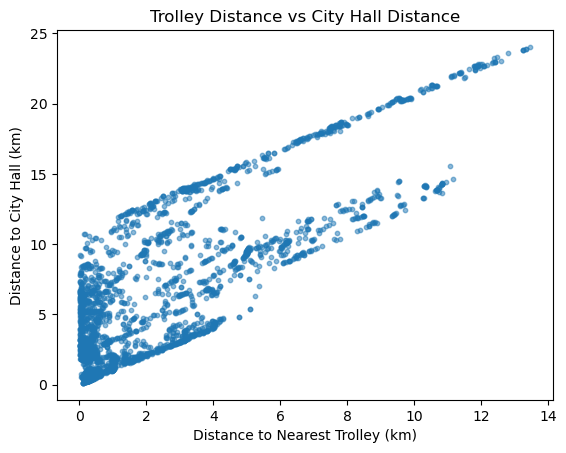

In [19]:
plt.scatter(df['trolley_distance_km'], df['city_hall_distance_km'],s=10,        # Marker size, try 5-20 depending on density
    alpha=0.5)
plt.xlabel('Distance to Nearest Trolley (km)')
plt.ylabel('Distance to City Hall (km)')
plt.title('Trolley Distance vs City Hall Distance')
plt.show()

In [20]:
all_features=['time','reviews','trolley_distance_km','city_hall_distance_km','price']

In [21]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
df_train, df_test = train_test_split(df,test_size=.2,random_state=42,stratify=df.category)

In [ ]:
X = df_train[all_features]  # Features
y = df_train['rating']  # Target

# Split the data into training and test sets (optional, can be done inside bootstrap)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to perform bootstrap cross-validation
def bootstrap_cv(X_train, y_train, model, n_iterations=len(df_train)//5):
    r2_scores = []
    mse_scores = []
    
    for _ in range(n_iterations):
        # Bootstrap sampling (sampling with replacement)
        indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
        X_bootstrap = X_train.iloc[indices]
        y_bootstrap = y_train.iloc[indices]
        
        # Train the model
        model.fit(X_bootstrap, y_bootstrap)
        
        # Out-of-bag samples (those not included in the bootstrap sample)
        oob_indices = np.setdiff1d(range(len(X_train)), indices)
        X_oob = X_train.iloc[oob_indices]
        y_oob = y_train.iloc[oob_indices]
        
        # Make predictions and calculate performance
        y_pred = model.predict(X_oob)
        
        # R2 score
        r2_scores.append(model.score(X_oob, y_oob))
        
        # Mean Squared Error
        mse_scores.append(mean_squared_error(y_oob, y_pred))
    
    return np.mean(r2_scores), np.mean(mse_scores)

# Define models
rf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, max_iter=10000))
])

# Perform Bootstrap Cross-Validation for Random Forest
rf_r2, rf_mse = bootstrap_cv(X_train, y_train, rf_model)
print(f"Random Forest (Bootstrap CV) - Average R²: {rf_r2:.4f}")
print(f"Random Forest (Bootstrap CV) - Average MSE: {rf_mse:.4f}")

# Perform Bootstrap Cross-Validation for Lasso
lasso_r2, lasso_mse = bootstrap_cv(X_train, y_train, lasso_model)
print(f"Lasso (Bootstrap CV) - Average R²: {lasso_r2:.4f}")
print(f"Lasso (Bootstrap CV) - Average MSE: {lasso_mse:.4f}") 
#abouve is the bootstrap method, which did not work well in our model, 
# thus we only list our attempt without using it in this model

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error

In [28]:
X_raw = df_train[all_features].copy()
y = df_train['rating']

# Square root transformation (clip negatives)
X_sqrt = np.sqrt(X_raw.clip(lower=0))
X_sqrt.columns = [f'sqrt_{col}' for col in X_sqrt.columns]

# Polynomial degree-2 features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X_raw), columns=poly.get_feature_names_out(all_features))

# Combine polynomial + sqrt
X_combined = pd.concat([X_poly.reset_index(drop=True), X_sqrt.reset_index(drop=True)], axis=1)

# --- Define Models ---
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0]))
])

lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], max_iter=10000))
])

rf_pipe = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

models = {
    'RidgeCV': ridge_pipe,
    'LassoCV': lasso_pipe,
    'Random Forest': rf_pipe,
}

# --- Evaluate Models ---
print("🔍 Cross-validation Scores (R² & MSE):\n")

for name, model in models.items():
    r2_scores = cross_val_score(model, X_combined, y, cv=5, scoring='r2')
    mse_scores = cross_val_score(model, X_combined, y, cv=5, scoring=make_scorer(mean_squared_error))
    
    print(f"{name}:")
    print(f"   Avg R²  : {r2_scores.mean():.4f}")
    print(f"   R² scores: {np.round(r2_scores, 4)}")
    print(f"   Avg MSE : {mse_scores.mean():.4f}")
    print(f"   MSE scores: {np.round(mse_scores, 4)}\n")

🔍 Cross-validation Scores (R² & MSE):

RidgeCV:
   Avg R²  : 0.1778
   R² scores: [0.1919 0.0999 0.1994 0.1974 0.2006]
   Avg MSE : 0.1655
   MSE scores: [0.1529 0.1839 0.155  0.1757 0.1601]

LassoCV:
   Avg R²  : 0.1426
   R² scores: [0.1548 0.103  0.1453 0.1781 0.1319]
   Avg MSE : 0.1725
   MSE scores: [0.1599 0.1832 0.1655 0.1799 0.1739]

Random Forest:
   Avg R²  : 0.2110
   R² scores: [0.2753 0.124  0.1408 0.2761 0.239 ]
   Avg MSE : 0.1587
   MSE scores: [0.1371 0.1789 0.1664 0.1584 0.1524]



In [29]:
rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_combined,y)

RandomForestRegressor(random_state=42)

In [32]:
importances = rf.feature_importances_

# Match with feature names
feature_importance = pd.Series(importances, index=X_combined.columns).sort_values(ascending=False)

print(feature_importance)

time city_hall_distance_km                   0.146408
reviews trolley_distance_km                  0.066462
reviews city_hall_distance_km                0.066244
time reviews                                 0.055624
time price                                   0.055303
trolley_distance_km city_hall_distance_km    0.054773
city_hall_distance_km price                  0.052105
time trolley_distance_km                     0.048272
trolley_distance_km price                    0.043108
reviews price                                0.039010
sqrt_time                                    0.038290
city_hall_distance_km                        0.035565
time                                         0.035090
time^2                                       0.034029
sqrt_city_hall_distance_km                   0.031152
city_hall_distance_km^2                      0.028973
trolley_distance_km                          0.023435
reviews^2                                    0.022664
reviews                     

In [33]:
X_test = df_test[all_features].copy()
y_test = df_test['rating']

# Square root features
X_sqrt_test = np.sqrt(X_test.clip(lower=0))
X_sqrt_test.columns = [f'sqrt_{col}' for col in X_sqrt_test.columns]

# Polynomial features using already fitted poly
X_poly_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(all_features))

# Combine features
X_combined_test = pd.concat([X_poly_test.reset_index(drop=True), X_sqrt_test.reset_index(drop=True)], axis=1)

# Predict and compute MSE
y_pred = rf.predict(X_combined_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")

Test MSE: 0.1520


In [34]:
residual = np.array(y_test) - np.array(y_pred)

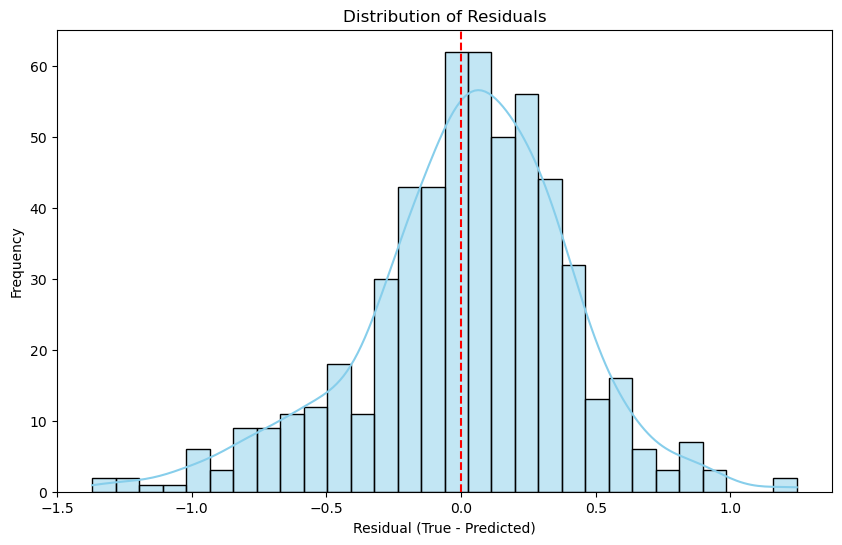

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(residual, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
current_features= #the features for a new restaurant
expeceted_rating=rf.predict(current_features)